In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import datetime as dt
%matplotlib inline
from matplotlib.pylab import rcParams
import datetime as dt
rcParams['figure.figsize']=10,6
from scipy.stats import boxcox
sns.set(style='darkgrid', context='talk', palette='Dark2')

In [2]:
df = pd.read_csv('prices-split-adjusted.csv', parse_dates= True, index_col=0)
df.head()


,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


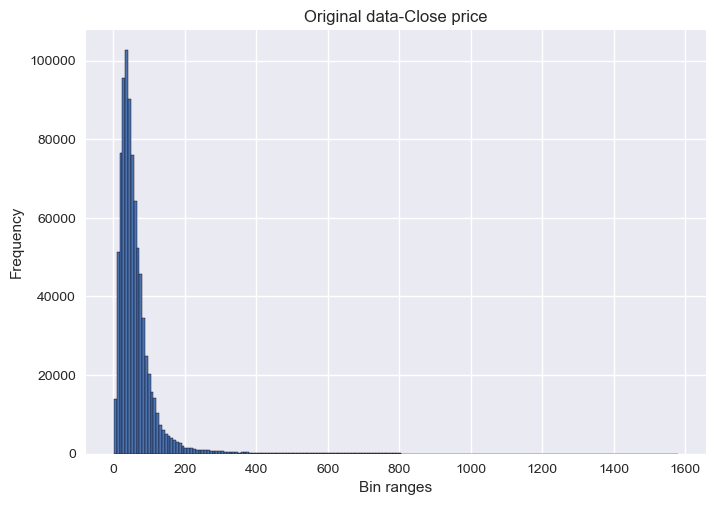

In [30]:
# Histogram of the Energy Star Score
rcParams['figure.figsize']=20,7
plt.style.use('seaborn')
plt.hist(df['close'], bins = 200, edgecolor = 'k');
plt.xlabel('Bin ranges'); plt.ylabel('Frequency'); 
plt.title('Original data-Close price');

In [33]:
price_min = df.close.min() # minimum price
price_min



1.59

In [34]:
price_max = df.close.max() # maximum price
price_max

1578.130005

In [36]:

from matplotlib import style
import mpl_finance
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from matplotlib.dates import num2date
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

C:\ProgramData\Anaconda3\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


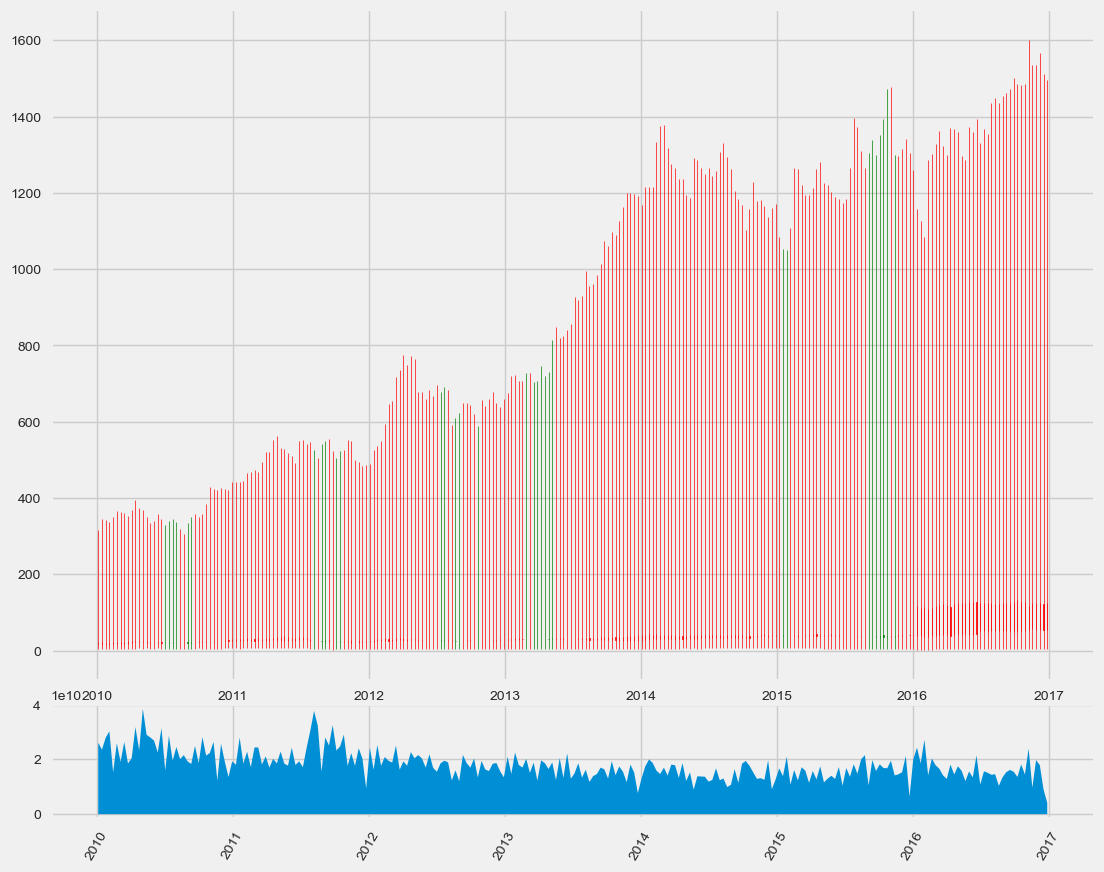

In [66]:
rcParams['figure.figsize'] = (12, 10)   # Change the size of plots
ohlc_dict = {                                                                                                             
'open':'first',                                                                                                    
'high':'max',                                                                                                       
'low':'min',                                                                                                        
'close': 'last',                                                                                                    
'volume': 'sum'
}

df.resample('5T', closed='left', label='left').apply(ohlc_dict)

df_ohlc = df.resample('10D', closed='left', label='left').apply(ohlc_dict)
df_ohlc.reset_index(inplace=True)
df_ohlc['date'] = df_ohlc['date'].map(mdates.date2num)
df_volume = df['volume'].resample('10D', closed='left', label='left').sum()

plt.style.use('fivethirtyeight')
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=5, colspan=1, sharex=ax1)

ax1.xaxis_date()


candlestick_ohlc(ax1, df_ohlc.values, colorup='g', colordown='r')
ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume,0 )
plt.xticks(rotation=60)
plt.show()

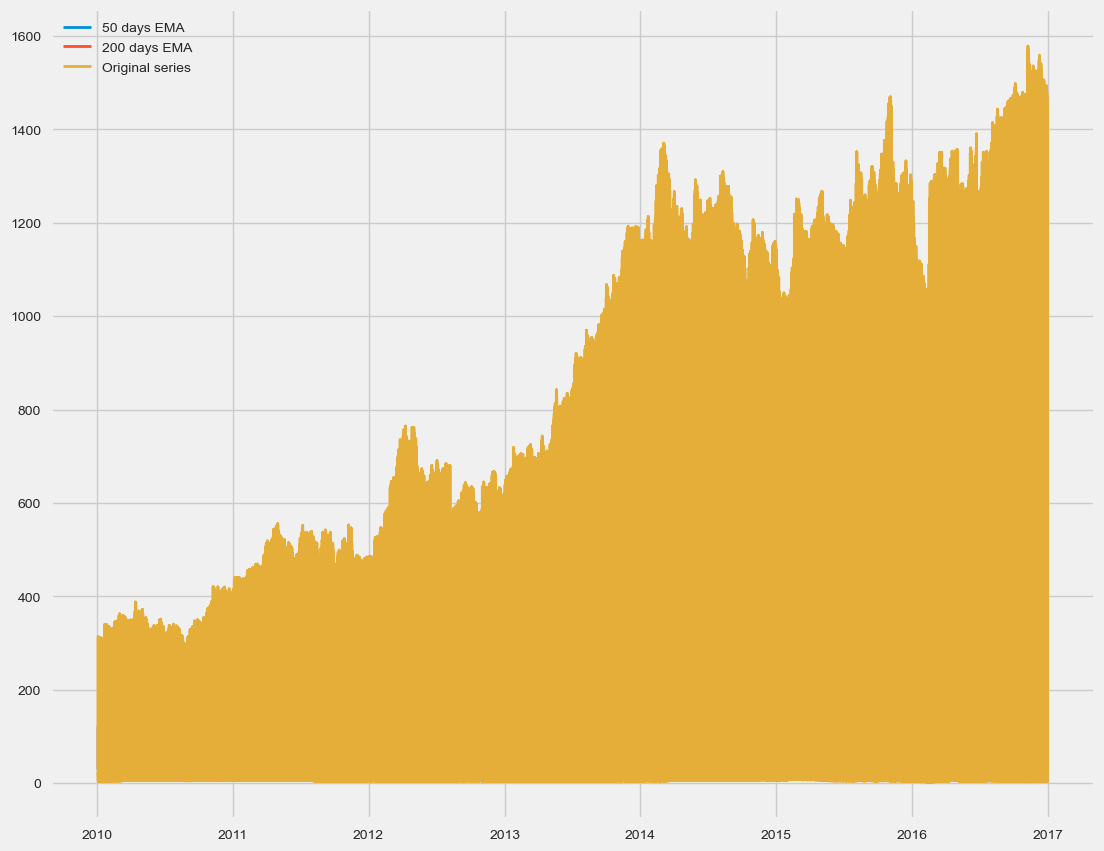

In [73]:

ema50 = df.close.ewm(span=50, adjust=False).mean() # span= 50 taken a short window
ema200 = df.close.ewm(span=200, adjust=False).mean() # span = 200 as per histogram above


plt.style.use('fivethirtyeight')
plt.plot(ema50, label= '50 days EMA',lw=2)
plt.plot(ema200, label= '200 days EMA',lw=2)
plt.plot(df.close, label= 'Original series',lw=2)
plt.legend(loc='best')
plt.show()

In [52]:
ema200.tail() # sanity check




date
2016-12-30    82.398519
2016-12-30    82.006892
2016-12-30    81.723539
2016-12-30    81.362609
2016-12-30    81.086662
Name: close, dtype: float64

In [53]:
df['ema50'] = ema50 # creating separate columns in original dataframe
df['ema200'] = ema200

# Taking the difference between the original price and the ema200 time series to determine trading position
trading_positions_raw = df.close - df.ema200
trading_positions_raw.tail()

date
2016-12-30    20.801478
2016-12-30   -38.966891
2016-12-30   -28.193540
2016-12-30   -35.912608
2016-12-30   -27.456661
dtype: float64

In [54]:
# Taking the sign of the difference pi(t) and the EMA ei(t) to determine whether the original price or the EMA is greater

trading_positions = trading_positions_raw.apply(np.sign)
trading_positions.tail()

date
2016-12-30    1.0
2016-12-30   -1.0
2016-12-30   -1.0
2016-12-30   -1.0
2016-12-30   -1.0
dtype: float64

In [55]:

trading_final = trading_positions.shift(1)
trading_final.tail()

date
2016-12-30   -1.0
2016-12-30    1.0
2016-12-30   -1.0
2016-12-30   -1.0
2016-12-30   -1.0
dtype: float64

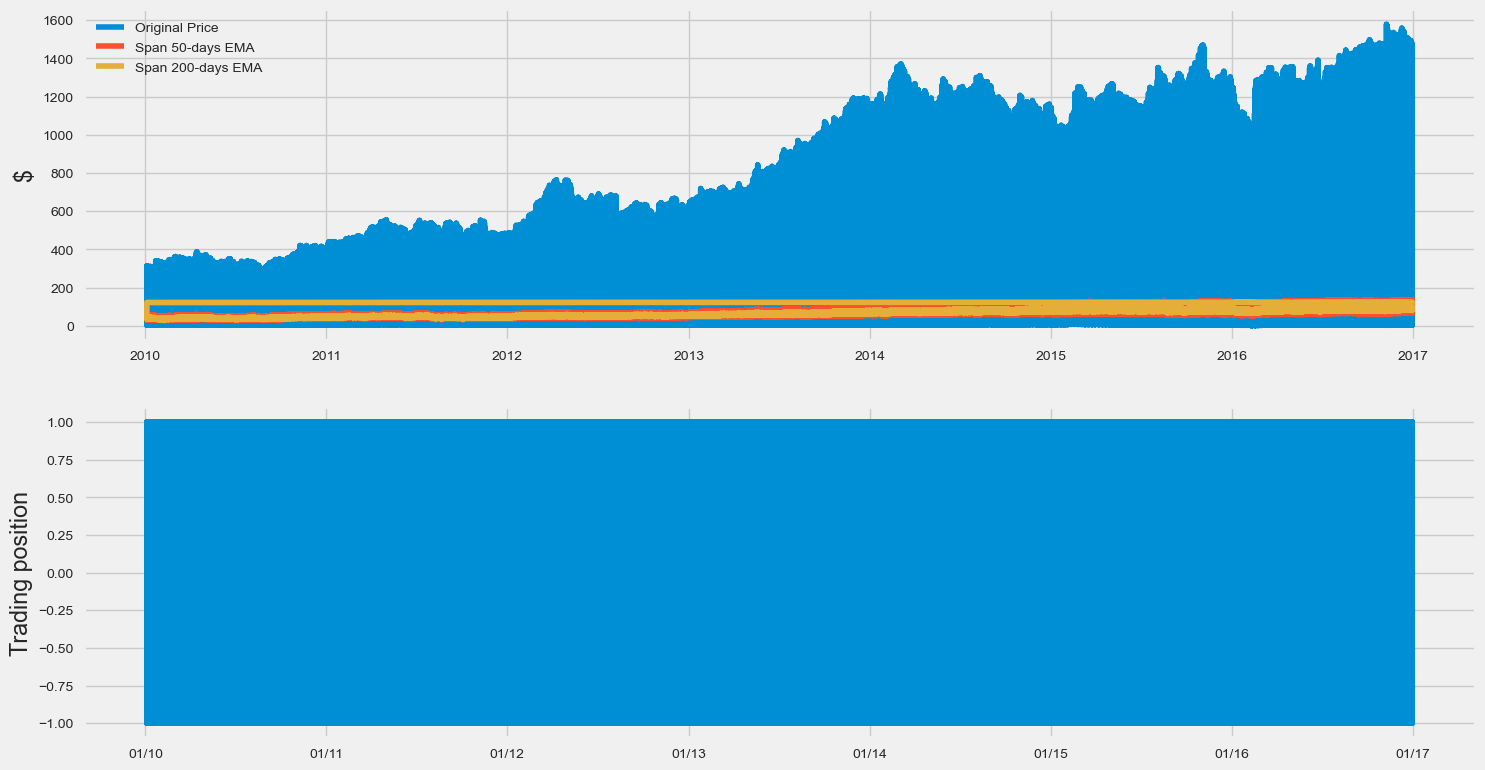

In [56]:
import matplotlib.dates as mdates
my_year_month_fmt = mdates.DateFormatter('%m/%y')

# plotting the timeseries and the respective trading position
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9)) 

plt.style.use('fivethirtyeight')
ax1.plot(df.close, label='Original Price')
ax1.plot(df.ema50, label = 'Span 50-days EMA')
ax1.plot(df.ema200, label = 'Span 200-days EMA')

ax1.set_ylabel('$')
ax1.legend(loc='best')


ax2.plot(trading_final, label='Trading position')
ax2.set_ylabel('Trading position')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

In [78]:
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
close_log = np.log(df.close).diff()
close_log.head()

date
2016-01-05         NaN
2016-01-06   -0.047686
2016-01-07   -0.042828
2016-01-08    0.014424
2016-01-11   -0.014250
Name: close, dtype: float64

In [79]:
strategy_returns = trading_final * close_log # To get all the strategy_returns for all days

# log-returns can be added to show performance across time, 
# so, plotted the cumulative log-returns and the cumulative total relative returns.
strategy_returns.tail()


date
2016-12-30   -0.488310
2016-12-30   -0.874539
2016-12-30   -0.218112
2016-12-30    0.163629
2016-12-30   -0.165496
dtype: float64

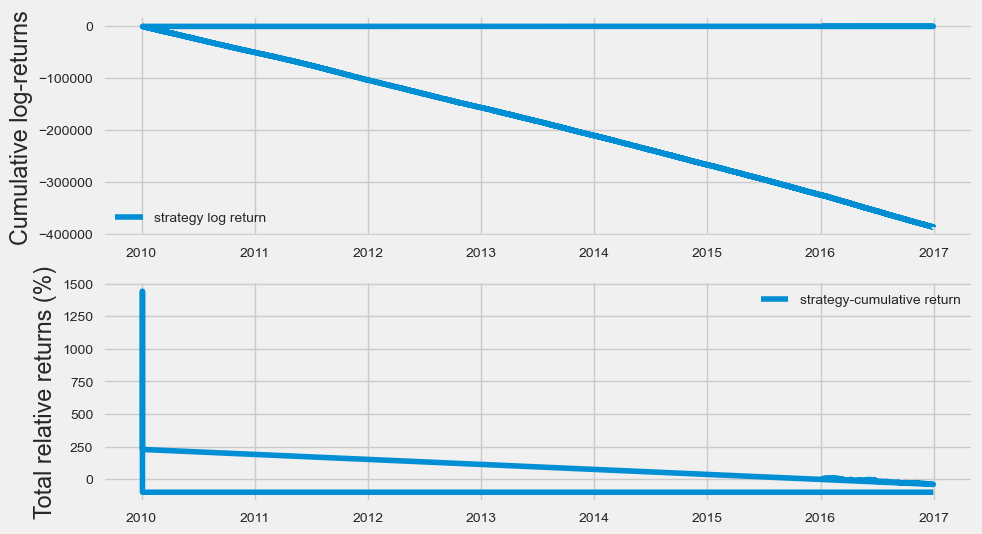

In [80]:
strategy_returns_cum = strategy_returns.cumsum()

# Transform the cumulative log returns to relative returns
strategy_returns_relative = np.exp(strategy_returns_cum) - 1

plt.style.use('fivethirtyeight')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))

ax1.plot(strategy_returns_cum, label='strategy log return')
ax1.set_ylabel('Cumulative log-returns')
ax1.legend(loc='best')


ax2.plot(100*strategy_returns_relative, label='strategy-cumulative return')
ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')